## Show difference between 3 subjects in keyboard dataset

In [1]:
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from q2_anomaly_detection.datasets import KeyboardDataset
from q2_anomaly_detection.benchmark import Benchmark
%matplotlib inline

In [2]:
RANDOM_SEED = 724
RAREFACTION_DEPTH = 500
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
dataset = KeyboardDataset('data/keyboard')

Files already downloaded and verified


In [3]:
TRAINING_CATEGORY = 'host_subject_id_for_surface'
TRUTH_CATEGORY = 'host_subject_id'

In [4]:
def construct_category(metadata):
    metadata['host_subject_id_for_surface'] = np.nan
    skin_samples = metadata.index[metadata.sample_type == 'skin']
    metadata.loc[:, 'host_subject_id_for_surface'].loc[skin_samples] = metadata.host_subject_id[
        skin_samples].to_numpy()


def subset_metadata(metadata_all):
    subject_ids = ['M2','M3', 'M9']
    metadata = metadata_all.query('host_subject_id in @subject_ids')
    return metadata

In [5]:
iso = IsolationForest(contamination="auto")
lof = LocalOutlierFactor(novelty=True,
                         contamination="auto",
                        )
lof_jaccard = LocalOutlierFactor(novelty=True,
                         contamination="auto",
                         metric='jaccard',
                        )
ocsvm = OneClassSVM(gamma='auto')

In [6]:
# CONVENTION: anomaly scores should be transformed onto (0, 1) where 1 is
#  least anomalous and 0 is the most anomalous
models = {
    'IF': {
        'model': iso,
    },
    'LOF': {
        'model': lof,
    },
    'LOF-jaccard': {
        'model': lof_jaccard,
    },
    'ocsvm': {
        'model': ocsvm,
    },
}

In [7]:
table = dataset['table']

In [8]:
table.shape

(2180, 115)

In [9]:
metadata_all = dataset['metadata']

In [10]:
metadata = subset_metadata(metadata_all)

In [11]:
metadata = metadata.set_index('sample_name')

In [12]:
metadata['sample_type'].unique()


array(['surface', 'skin'], dtype=object)

In [13]:
construct_category(metadata)

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
table.filter(metadata.index, axis='sample')

2180 x 104 <class 'biom.table.Table'> with 12380 nonzero entries (5% dense)

In [15]:
np.random.seed(RANDOM_SEED)
subtable = table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [16]:
subtable.shape

(1421, 99)

In [17]:
study_ids = subtable.ids('sample')

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


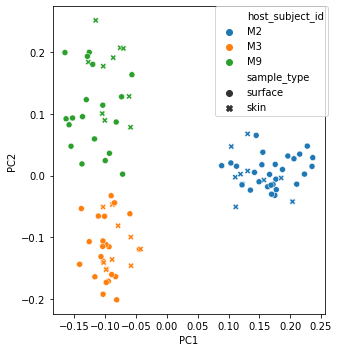

In [18]:
dm = pdist(subtable.matrix_data.todense().transpose(), metric='jaccard')

pcoa_results = pcoa(dm)

pcoa_results.samples.index = study_ids

pcoa_with_metadata = pcoa_results.samples.join(metadata)

plt.subplots(figsize=(10, 5))
ax = sns.scatterplot('PC1', 'PC2',
                     hue='host_subject_id',
                     style='sample_type',
                     data=pcoa_with_metadata
                     )
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()

## Show the results of an anomaly detection algorithm of one class v. rest



In [19]:
benchmark = Benchmark(models)
all_results = benchmark.benchmarking_loop(subtable, submetadata, TRUTH_CATEGORY, TRAINING_CATEGORY)


/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neigh

In [20]:
res_df = all_results.long_form()

In [21]:
res_with_pc = res_df.reset_index().join(
    pcoa_results.samples[['PC1', 'PC2', 'PC3']], on='sample_id'
).join(
    metadata[['sample_type']], on='sample_id'
)

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


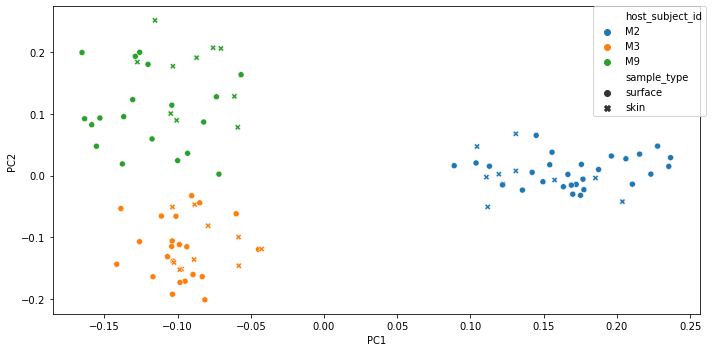

In [22]:
plt.subplots(figsize=(10, 5))
sns.scatterplot('PC1', 'PC2',
                hue='host_subject_id',
                style='sample_type',
                data=pcoa_with_metadata)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()

In [23]:
sns.set(font_scale=1.5)

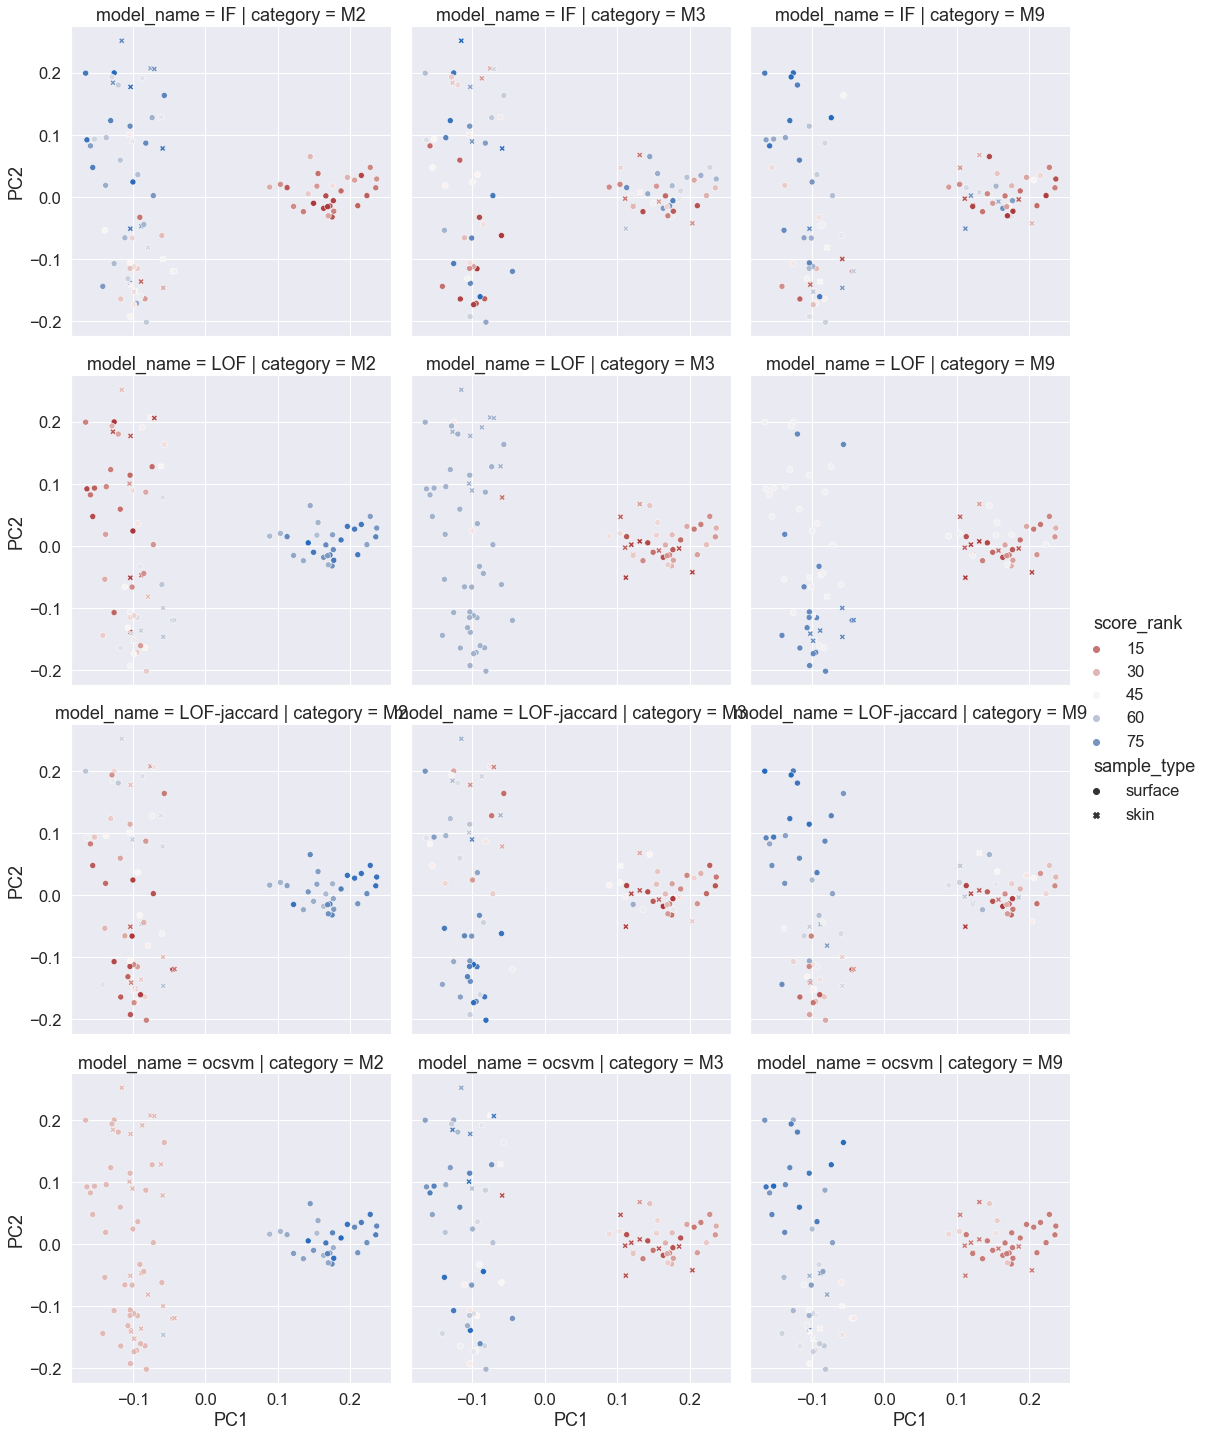

In [24]:
ax = sns.relplot(x='PC1', y='PC2',
            data=res_with_pc,
            col='category',
            row='model_name',
            hue='score_rank',
            palette='vlag_r',
            style='sample_type',
            aspect=1,
           )

In [25]:
all_results.short_form()


,model_name,category,roc_auc,avg_prec
0,IF,M2,0.031616,0.478482
1,IF,M3,0.404342,0.669432
2,IF,M9,0.848872,0.955481
3,LOF,M2,1.000000,1.000000
4,LOF,M3,0.805970,0.904075
5,LOF,M9,0.617669,0.867001
6,LOF-jaccard,M2,1.000000,1.000000
7,LOF-jaccard,M3,0.946744,0.982288
8,LOF-jaccard,M9,0.984962,0.996042
9,ocsvm,M2,1.000000,1.000000
